In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from src.dqn.DQNAgent import DQNAgent
from src.dqn.ReplayBuffer import ReplayBuffer
from src.ProbBidClearing import ProbBidClearing

In [2]:
# load day-ahead and real-time prices
DAP = pd.read_csv("./data/CAISO_DAP.csv")
RTP = pd.read_csv("./data/CAISO_RTP.csv")

# read datetime and drop duplicate data
RTP["Date"] = pd.to_datetime(RTP["Date"], format="%m/%d/%Y %I:%M:%S %p")
RTP = RTP.drop_duplicates(subset=["Date", "hub"])
DAP["Date"] = pd.to_datetime(DAP["Date"], format="%m/%d/%Y %I:%M:%S %p")
DAP = DAP.drop_duplicates(subset=["Date", "zone"])

# pivot data
DAP_pivoted = DAP.pivot(index="Date", columns="zone", values="price")
RTP_pivoted = RTP.pivot(index="Date", columns="hub", values="price")

# rename 'Date' column to 'ts'
DAP_pivoted.index.names = ["ts"]
RTP_pivoted.index.names = ["ts"]

# merge dataframes on index
CAISO_PRICES = pd.merge(DAP_pivoted, RTP_pivoted, on=["ts"], how="outer")
CAISO_PRICES = CAISO_PRICES.ffill().reset_index()

In [3]:
# form datasets
PGAE_NP15 = CAISO_PRICES[["ts", "PGAE", "TH_NP15"]].rename(
    columns={"PGAE": "dap", "TH_NP15": "rtp"}
)
PGAE_ZP26 = CAISO_PRICES[["ts", "PGAE", "TH_ZP26"]].rename(
    columns={"PGAE": "dap", "TH_ZP26": "rtp"}
)
SCE_SP15 = CAISO_PRICES[["ts", "SCE", "TH_SP15"]].rename(
    columns={"SCE": "dap", "TH_SP15": "rtp"}
)
SDGE_SP15 = CAISO_PRICES[["ts", "SDGE", "TH_SP15"]].rename(
    columns={"SDGE": "dap", "TH_SP15": "rtp"}
)

In [4]:
# Hyperparameters
lr = 1e-3
batchsize = 128
maxlength = 10000
episodes = 5
initialsize = 5000
tau = 100
epsilon = 0.2
gamma = 0.99

In [5]:
# init the prob clearer

clearer = ProbBidClearing()
prob_clear_function = clearer.timevarying_norm_prob_clear

In [6]:
# init DQN Agent
agent = DQNAgent(lr=lr, 
                 prob_clear=prob_clear_function,
                 attitude="risky",
                 data=PGAE_NP15
                )

# init Replay Buffer
buffer = ReplayBuffer(maxlength=maxlength)

In [7]:
agent.train(buffer, gamma, initialsize, batchsize, tau, episodes)

/Users/shadunts/Documents/study/ORCSE4529/EnergyStorageRLBidder/src/dqn/DQNAgent.py:228: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  states = torch.FloatTensor(states)


Episode 0, Overall Reward: 10670.373331427203
Episode 1, Overall Reward: 9513.204746383168
Episode 2, Overall Reward: 10809.093775712327
Episode 3, Overall Reward: 13791.040841381426
Episode 4, Overall Reward: 9604.403136760498


Text(0, 0.5, 'Profit')

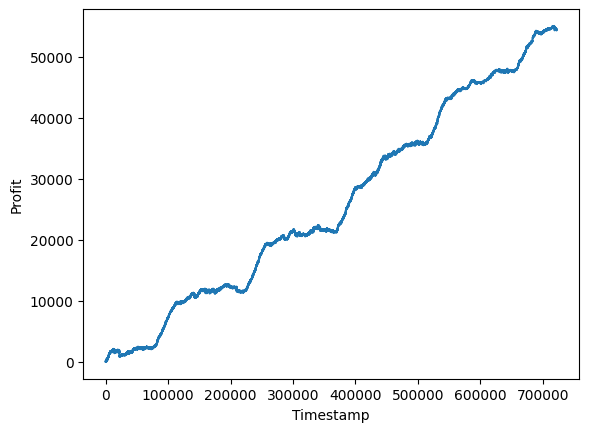

In [8]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(agent.profit_hist))
plt.xlabel("Timestamp")
plt.ylabel("Profit")

In [9]:
import pickle as pkl

agent._reset_sim()

with open('agents/timevarying_norm_honest.pkl', 'wb') as f:
    pkl.dump(agent, f)